In [30]:
import torch
import pytorch_lightning as pytorch_lightning
import sys

sys.path.append('./lhdm')
sys.path.append('./lhdm/data')

from irn_dataset import DataHandler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hparams = {
    "split_ratio": [80, 10, 10],
    "device": device,
    "batch_size": 8,
    "num_workers": 4,
    "sample_limit": 1,
    "input_dim": 1185,
    "output_dim": 1185,
    "hidden_dim": 512,
    "z_dim": 64
}
datahandler = DataHandler(hparams, "lhdm/data/mnist-inrs", "cifar10_png_train_airplane_")

train_loader = datahandler.train_dataloader()
val_loader = datahandler.val_dataloader()
next(iter(train_loader))

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

tensor([[-0.0300, -0.0620,  0.0023,  ...,  0.0232,  0.1365,  0.0003]])

In [32]:
import sys
sys.path.append('./lhdm/models')

from mlp_models import MLP
from inr import INR
state_dict = datahandler.get_state_dict(index=0)

params = {
    "input_size": 2,
    "hidden_size": 32,
    "output_size": 1
}

#mlp = MLP(params)
mlp = INR(up_scale=16)
print(mlp)
mlp.load_state_dict(state_dict)
test_input = torch.randn(2)
print(test_input)
print(mlp(test_input))


INR(
  (seq): Sequential(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
tensor([-0.8209,  1.6730])
tensor([0.2514], grad_fn=<AddBackward0>)


/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(mlp_model):
    # Generate a 28x28 grid of (x, y) inputs
    resolution = 28
    x = np.linspace(-1, 1, resolution)  # Normalize to range [-1, 1]
    y = np.linspace(-1, 1, resolution)
    grid_x, grid_y = np.meshgrid(x, y)

    # Flatten the grid into a list of (x, y) pairs
    inputs = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)
    #print(inputs)
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

    # Pass the inputs through the MLP
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = mlp_model(inputs_tensor).numpy()

    # Reshape the outputs into a 28x28 image
    image = outputs.reshape(resolution, resolution)

    # Plot the image
    plt.imshow(image, cmap="gray", extent=(-1, 1, -1, 1))
    plt.colorbar(label="Grayscale Value")
    plt.title("Generated Grayscale Image")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [34]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import WandbLogger
from models import Autoencoder

wandb_logger = WandbLogger(log_model="all")
trainer = pl.Trainer(logger=wandb_logger, max_epochs=10)

model = Autoencoder(ddconfig=hparams, embed_dim=16)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/simon/anaconda3/envs/lhdm/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/simon/anaconda3/envs/lhdm/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./lightning_logs/6nd4w2gf/checkpoints exists and is not empty.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 640 K  | train
1 | decoder | Decoder | 641 K  | train
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.125     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/simon/anaconda3/envs/lhdm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.26it/s, v_num=w2gf, aeloss_step=0.00226]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 0: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.00226, aeloss_epoch=0.00226]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=w2gf, aeloss_step=0.00133, aeloss_epoch=0.00226]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 1: 100%|██████████| 1/1 [00:08<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.00133, aeloss_epoch=0.00133]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 2: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=w2gf, aeloss_step=0.000742, aeloss_epoch=0.00133]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 2: 100%|██████████| 1/1 [00:08<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.000742, aeloss_epoch=0.000742]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 3: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=w2gf, aeloss_step=0.000477, aeloss_epoch=0.000742]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 3: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=w2gf, aeloss_step=0.000477, aeloss_epoch=0.000477]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 4: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=w2gf, aeloss_step=0.000331, aeloss_epoch=0.000477]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 4: 100%|██████████| 1/1 [00:08<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.000331, aeloss_epoch=0.000331]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 5: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=w2gf, aeloss_step=0.000245, aeloss_epoch=0.000331]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 5: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=w2gf, aeloss_step=0.000245, aeloss_epoch=0.000245]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 6: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=w2gf, aeloss_step=0.000182, aeloss_epoch=0.000245]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 6: 100%|██████████| 1/1 [00:08<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.000182, aeloss_epoch=0.000182]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 7: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=w2gf, aeloss_step=0.000153, aeloss_epoch=0.000182]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 7: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=w2gf, aeloss_step=0.000153, aeloss_epoch=0.000153]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=w2gf, aeloss_step=0.000153, aeloss_epoch=0.000153]        

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 8: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=w2gf, aeloss_step=0.000144, aeloss_epoch=0.000144]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 9: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=w2gf, aeloss_step=0.000119, aeloss_epoch=0.000144]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 9: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.000119, aeloss_epoch=0.000119]

/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

Epoch 9: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=w2gf, aeloss_step=0.000119, aeloss_epoch=0.000119]


/home/simon/Documents/Studium/University/Master/1.Semester/Advanced DL for Computer Vision/lhdm/data/irn_dataset.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

[[-1.         -1.        ]
 [-0.92592593 -1.        ]
 [-0.85185185 -1.        ]
 ...
 [ 0.85185185  1.        ]
 [ 0.92592593  1.        ]
 [ 1.          1.        ]]


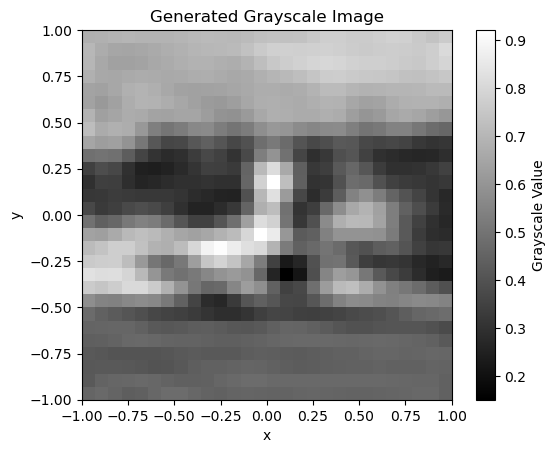

[[-1.         -1.        ]
 [-0.92592593 -1.        ]
 [-0.85185185 -1.        ]
 ...
 [ 0.85185185  1.        ]
 [ 0.92592593  1.        ]
 [ 1.          1.        ]]


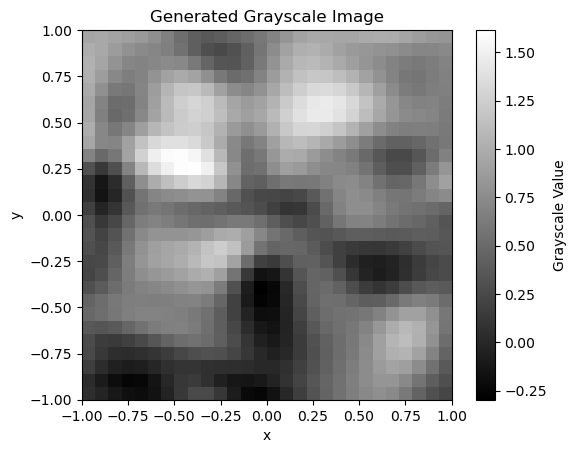

In [37]:
weights = model(next(iter(train_loader))).flatten()

mlp_reconstructed = INR(up_scale=16)
state_dict = mlp_reconstructed.state_dict()
it = 0
for k,v in state_dict.items():
    num_param = v.numel()

    values = weights[it:it+num_param]

    reshaped_values = values.view_as(v)

    state_dict[k] = reshaped_values

    it += num_param
mlp_reconstructed.load_state_dict(state_dict)
plot_image(mlp)
plot_image(mlp_reconstructed)